In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from pyarrow import parquet 
import numpy as np


og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet').to_pandas()



In [2]:
len(og_aspect)

43094680

In [ ]:
new_asp['time'].iloc[0]

In [ ]:
plt.scatter(new_asp['time'].iloc)

In [ ]:
print(type(og_aspect['flags'].iloc[0]))
print(type(new_asp['flags'].iloc[0]))

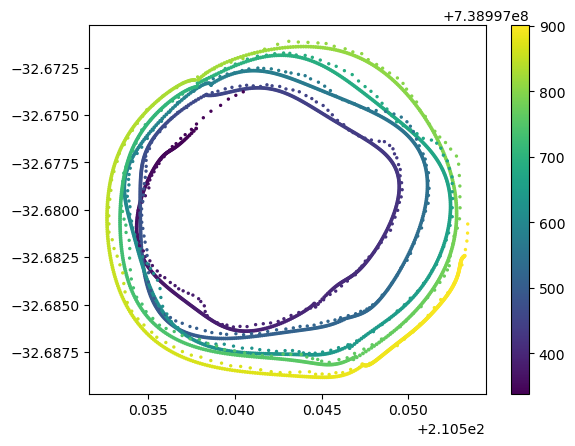

In [4]:
plt.scatter(new_asp['ra'],new_asp['dec'],c=new_asp['time'],s=3)
plt.scatter(og_aspect['ra'],og_aspect['dec'],c=og_aspect['time'],s=2)
plt.colorbar()

In [5]:
plt.scatter(new_asp['time'],new_asp['roll'],s=3)
plt.scatter(og_aspect['time'],og_aspect['roll'],s=2)
plt.colorbar()

KeyError: 'orientation'

In [ ]:
new_asp['flags'].iloc[5]

In [2]:

def fit_curves(fit_time, new_aspect_file, order):
    """ fit a polynomial to the new aspect solution every 60 s and 
    double the time resolution of output aspect parquet before sending to gPhoton
    (ie a point every .5 seconds). this helps to reduce the effect of occassional
    poor aspect solutions. weighted by the 'logodds' output by astrometry.net to 
    allow the 'best' aspect solns to have the most say. """ 
    
    asp_new_raw = pd.read_csv(new_aspect_file)
    
    ## TO DELETE#
    #asp_new_raw = asp_new_raw.rename(columns={"ra": "ra_center", "dec": "dec_center",
    #                                          "time": "mission_time", "roll":"orientation",
    #                                         "flags": "flags_x"})
    #print(asp_new_raw)
    #asp_new_raw['logodds'] = 1
    ##########
    
    length = asp_new_raw['mission_time'].iloc[-1] - asp_new_raw['mission_time'].iloc[0] 
    
    print(f"This leg of eclipse {eclipse} is {length} seconds long.")
    
    # how many rounds of poly fitting will we have to do for a given fit_time? 
    groups = length // fit_time + (length % fit_time > 0)
    
    group_dict = {x: (x*fit_time + asp_new_raw['mission_time'].iloc[0],
                      (x+1)*fit_time + asp_new_raw['mission_time'].iloc[0])
                  for x in range(int(groups))}
    
    print(f"There are {groups} groups.")
    
    polyfit_aspect = pd.DataFrame() 
    
    for i in group_dict: 
        group = asp_new_raw.loc[(asp_new_raw['mission_time'] >= group_dict[i][0]) & 
                                (asp_new_raw['mission_time'] <= group_dict[i][1])]
        polyfit_dict = get_group_curve(group, order, fit_time)
        polyfit_group_aspect = pd.DataFrame.from_dict(polyfit_dict)
        
        polyfit_aspect = pd.concat([polyfit_aspect, polyfit_group_aspect], ignore_index=True)
    
    polyfit_aspect['frame_type'] = 'poly'
    polyfit_aspect['flags_x'] = 0
    polyfit_aspect['logodds'] = 0 
    polyfit_aspect['time'] = 0 

    return polyfit_aspect 


def get_group_curve(group, order, fit_time): 

        time = group['mission_time']-group['mission_time'].iloc[0]
        dec = group['dec_center']
        ra = group['ra_center']
        orientation = group['orientation']+360
        logodds = group['logodds']
        
        # fitting curves
        new_time = np.linspace(min(time), max(time), fit_time*4)
        print(new_time)
        #new_time = np.arange(min(time), min(time)+fit_time, 1)
        # RA 
        ra_coefficients = np.polyfit(time, ra, order,  w=logodds)
        ra_fitted_curve = np.poly1d(ra_coefficients)
        # DEC 
        dec_coefficients = np.polyfit(time, dec, order,  w=logodds)
        dec_fitted_curve = np.poly1d(dec_coefficients)
        # ROLL 
        roll_coefficients = np.polyfit(time, orientation, order,  w=logodds)
        roll_fitted_curve = np.poly1d(roll_coefficients)
        
        # get new interpolated / fit aspect soln per group 
        real_time = new_time + group['mission_time'].iloc[0] # getting the big real time back 
        new_ra = ra_fitted_curve(new_time)
        new_dec = dec_fitted_curve(new_time)
        new_roll = roll_fitted_curve(new_time)
        
        return {'mission_time':real_time, 'ra_center':new_ra, 'dec_center':new_dec, 'orientation':new_roll} 
    
    
def write_aspect2(eclipse, file_names):
    """takes refined aspect table df and turns it into an aspect2 parquet
     file formatted the same as the og aspect parquet file so it can be
      read by gphoton, overwrites whatever is previously called
      aspect2.parquet in the gphoton aspect folder. adds time and flag
      info from og aspect."""
    import numpy as np
    import os
    import sys
    import shutil
    import pandas as pd
    # loading aspect table to add time stamp and flags
    if os.path.exists(file_names['new_asp_poly']):
        new_aspect_df = pd.read_csv(file_names['new_asp_poly'])
        df2 = new_aspect_df.filter(['mission_time',
                                    'ra_center',
                                    'dec_center',
                                    'orientation',
                                    'flags_x',
                                    'logodds',
                                    'frame_type'],
                                    axis=1)
        df2['eclipse'] = eclipse
        # have to rename columns to ra, dec, and roll
        # bc that's how og aspect parq is
        df2 = df2.rename(columns={"ra_center": "ra",
                                  "dec_center": "dec",
                                  "orientation": "roll",
                                  "mission_time": "time",
                                  "flags_x": "flags"})
        # for ValueError("cannot reindex on an axis with duplicate labels")
        # idk if this should be a permanent solution or not
        df2 = df2[~df2.index.duplicated()]
        df2 = df2.astype({'ra': 'float64',
                          'dec': 'float64',
                          'roll': 'float64',
                          'time': 'float64',
                          'logodds': 'float64',
                          'flags': 'uint8'})
        # save to parquet
        df2.to_parquet(file_names["aspect_parq"], compression=None)
    elif not os.path.exists(file_names['new_asp_poly']):
        print("new aspect solution does not exist.")
        return
    return

In [ ]:
new_aspect_file = "/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv"
eclipse = 580 
band = "NUV"
order = 7
filenames = {'new_aspect': new_aspect_file, 
             'new_asp_poly': "/home/bekah/gPhoton2/gPhoton/aspect/interpolated.csv",
             'aspect_parq': "/home/bekah/gPhoton2/gPhoton/aspect/aspect2.parquet" }

fit_time = 60 # 60 seconds to fit poly over 

print("Fitting new aspect.")
polyfit_aspect = fit_curves(fit_time, new_aspect_file, order)

print("Saving new aspect to csv.")
polyfit_aspect.to_csv(filenames['new_asp_poly'])

print("Writing aspect.")
write_aspect2(eclipse, filenames)

In [3]:
import sys 
sys.path.append('/home/bekah/gPhoton2')
from gPhoton.pipeline import execute_pipeline
eclipse = 580 
band = "NUV"
execute_pipeline(
        eclipse,
        band,
        depth=None,
        threads=4,
        verbose=10,
        local_root="/home/bekah/gPhoton2/new_asp580",
        recreate=False,
        aperture_sizes=[12.8],
        write={"movie": False, "image": True},
        compression="rice",
        lil=True,
        burst=False,
        extended_photonlist=True,
        aspect="aspect2")

starting timer
eclipse 580 NUV  -- NGS; 0 leg(s)
Processing eclipse 580
trange= ( 738997342.995 , 738997897.995 )                   
RA AVG: 210.54271325645067, DEC AVG: -32.680920005228835, ROLL AVG: 360.11413672241173
Loading raw6 file...                                        
19703741 events
Unpacking raw6 data...                                      
stim_coef0, stim_coef1 = -80175.12576700919, 0.00011540141996862803
aspect ratiopolating aspect_data solutions...               
t[ok_indices]
[7.3899743e+08 7.3899743e+08 7.3899743e+08 ... 7.3899746e+08 7.3899746e+08
 7.3899746e+08]
asptime[aspect_slice]
[7.38997430e+08 7.38997430e+08 7.38997430e+08 ... 7.38997459e+08
 7.38997459e+08 7.38997459e+08]
asptime[aspect_slice +1]
aspect ratio
[7.38997431e+08 7.38997431e+08 7.38997431e+08 ... 7.38997460e+08
 7.38997460e+08 7.38997460e+08]t[ok_indices]

[7.38997372e+08 7.38997372e+08 7.38997372e+08 ... 7.38997401e+08
 7.38997401e+08 7.38997401e+08]
aspect ratioasptime[aspect_slice]

t[ok_ind

RuntimeError: Couldn't build output array

In [ ]:
new_aspect_file = "/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv"
eclipse = 580 
band = "NUV"
order = 7
filenames = {'new_aspect': new_aspect_file, 
             'new_asp_poly': "/home/bekah/gPhoton2/gPhoton/aspect/interpolated.csv",
             'aspect_parq': "/home/bekah/gPhoton2/gPhoton/aspect/aspect2.parquet" }

print("Writing aspect.")
write_aspect2(eclipse, filenames)

import sys 
sys.path.append('/home/bekah/gPhoton2')
from gPhoton.pipeline import execute_pipeline

execute_pipeline(
        eclipse,
        band,
        depth=None,
        threads=4,
        verbose=10,
        local_root="/home/bekah/gPhoton2/new_asp580",
        recreate=False,
        aperture_sizes=[12.8],
        write={"movie": False, "image": True},
        compression="rice",
        lil=True,
        burst=False,
        extended_photonlist=True,
        aspect="aspect2")

In [ ]:
from astropy.io import fits
from compare_aspect.plots import centile_clip


e580 = fits.open("/home/bekah/gPhoton2/og_asp_580/e00580/e00580-nd-b00-ffull-image-r.fits")

plt.imshow(centile_clip(e580[1].data))

In [ ]:
e580_new = fits.open("/home/bekah/gPhoton2/new_asp580/e00580/e00580-nd-b00-ffull-image-r.fits")

plt.imshow(centile_clip(e580_new[1].data))

In [ ]:
times = [0.25157233  ,0.50314465 , 0.75471698 , 1.00628931  ,1.25786164,
  1.50943396 , 1.76100629 , 2.01257862 , 2.26415094 , 2.51572327,  2.7672956,
  3.01886792,  3.27044025,  3.52201258,  3.77358491,  4.02515723]

np.diff(times)